In [ ]:
!pip install face_recognition opencv-python scikit-learn seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=abff46e8262757c95cf6db762c1986220701aaf38e8190d6721bc2f0847c5bc6
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


# [Reconhecimento facial simples com Python](https://lisa-terumi.medium.com/reconhecimento-facial-simples-com-python-9b338af6d98d)

In [ ]:
!pip install --upgrade dlib face_recognition_models Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 65.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=40d8a8072384587c15b5e87e2f89034332234761a7189b2e19eadf37b043608d
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
emotion_translation = {
    "angry": "raiva",
    "disgust": "desgosto",
    "fear": "medo",
    "happy": "feliz",
    "sad": "triste",
    "surprise": "surpresa",
    "neutral": "neutro"
}

In [ ]:
# -*- coding: utf-8 -*-
import joblib  # Biblioteca para salvar e carregar modelos
import os
import PIL.Image
import dlib
import numpy as np
from PIL import ImageFile, ImageDraw, ImageFont
import face_recognition_models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import PIL.ImageDraw
import PIL.ImageFont
from PIL import Image
from scipy.spatial.distance import euclidean
from deepface import DeepFace  # Importar a biblioteca DeepFace para análise de emoções


#Esta linha permite que imagens truncadas ou incompletas sejam carregadas, evitando erros ao abrir essas imagens.
ImageFile.LOAD_TRUNCATED_IMAGES = True

'''
Essas variáveis inicializam modelos de detecção facial e predição de pontos faciais.
face_detector usa o modelo HOG para localizar rostos,
enquanto cnn_face_detector usa uma rede neural.
face_encoder gera descritores faciais, que são vetores únicos para cada rosto.

'''
face_detector = dlib.get_frontal_face_detector()
pose_predictor_68_point = dlib.shape_predictor(face_recognition_models.pose_predictor_model_location())
cnn_face_detector = dlib.cnn_face_detection_model_v1(face_recognition_models.cnn_face_detector_model_location())
face_encoder = dlib.face_recognition_model_v1(face_recognition_models.face_recognition_model_location())

def save_model(clf, scaler, names, file_path):
    """Salva o modelo, scaler e os nomes em um arquivo .h5"""
    model_data = {
        'clf': clf,
        'scaler': scaler,
        'names': names
    }
    joblib.dump(model_data, file_path)
    print(f"Modelo salvo em: {file_path}")

def load_model(file_path):
    """Carrega o modelo, scaler e nomes de um arquivo .h5"""
    if os.path.exists(file_path):
        model_data = joblib.load(file_path)
        print(f"Modelo carregado de: {file_path}")
        return model_data['clf'], model_data['scaler'], model_data['names']
    else:
        raise FileNotFoundError(f"Arquivo não encontrado: {file_path}")

# Funções auxiliares para carregar e processar imagens
def load_image_file(file, mode='RGB'):
    im = PIL.Image.open(file)
    if mode:
        im = im.convert(mode)
    return np.array(im)

def load_images_from_folder(folder):
    images = []
    names = []

    for name in os.listdir(folder):
        person_folder = os.path.join(folder, name)
        if os.path.isdir(person_folder):
            for image_name in os.listdir(person_folder):
                image_path = os.path.join(person_folder, image_name)
                image = load_image_file(image_path)
                encoding = face_encodings(image)
                if encoding:
                    images.append(encoding[0])
                    names.append(name)

    return np.array(images), np.array(names)

'''Essas funções detectam e codificam características faciais para cada rosto na imagem.
 _raw_face_locations detecta os rostos, _raw_face_landmarks identifica pontos específicos no rosto,
 e face_encodings gera um descritor para cada rosto.'''
'''
 em um espaço dimensional específico, aqui com 128 valores. Cada número reflete uma característica extraída do rosto,
 como a distância entre os olhos, o formato do queixo, a largura do nariz, e outras propriedades distintivas.
 Ele age como uma codificação matemática do rosto,
 permitindo que o sistema diferencie entre rostos de pessoas distintas com base em características únicas.
'''
def face_encodings(face_image, known_face_locations=None, num_jitters=1):
    raw_landmarks = _raw_face_landmarks(face_image, known_face_locations)
    return [np.array(face_encoder.compute_face_descriptor(face_image, raw_landmark_set, num_jitters)) for raw_landmark_set in raw_landmarks]

def _raw_face_landmarks(face_image, face_locations=None):
    if face_locations is None:
        face_locations = _raw_face_locations(face_image)
    return [pose_predictor_68_point(face_image, face_location) for face_location in face_locations]

def _raw_face_locations(img, number_of_times_to_upsample=1, model="hog"):
    if model == "cnn":
        return cnn_face_detector(img, number_of_times_to_upsample)
    else:
        return face_detector(img, number_of_times_to_upsample)

# Função para exibir a matriz de confusão
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Matriz de Confusão')
    plt.show()

def process_new_image(image_path, model_path, threshold=0.6):
    clf, scaler, names = load_model(model_path)
    image = load_image_file(image_path)
    face_locations = _raw_face_locations(image)
    face_encodings_list = face_encodings(image, face_locations)
    scaled_encodings_list = scaler.transform(face_encodings_list)

    pil_image = Image.fromarray(image)
    draw = PIL.ImageDraw.Draw(pil_image)

    for i, face_location in enumerate(face_locations):
        print("**********************************************************\n")
        top, right, bottom, left = face_location.top(), face_location.right(), face_location.bottom(), face_location.left()

        draw.rectangle([(left, top), (right, bottom)], outline="red", width=3)

        encoding = scaled_encodings_list[i]

        probabilities = clf.predict_proba([encoding])[0]
        max_prob = max(probabilities)

        if max_prob < threshold:
            predicted_name = "Pessoa Desconhecida"
        else:
            predicted_name = clf.predict([encoding])[0]

        print(f"Rosto identificado: {predicted_name}")

        # Detecção de emoções com DeepFace
        emotion_analysis = DeepFace.analyze(image_path, actions=['emotion'], enforce_detection=False)
        dominant_emotion = emotion_analysis[0]['dominant_emotion']

        # Traduzir emoção
        translated_emotion = emotion_translation.get(dominant_emotion, "desconhecida")
        print(f"Emoção detectada (traduzida): {translated_emotion} \n")

        print("TOPO: ", int(face_location.top()))
        print("DIREITA: ", int(face_location.right()))
        print("BAIXO: ", int(face_location.bottom()))
        print("ESQUERDA: ", int(face_location.left()))

        print("VETOR CARACTERISTICAS: ", encoding, "\n")

        # Adicionar emoção detectada na imagem
        font = PIL.ImageFont.load_default()
        draw.text((left, top - 10), f"{predicted_name} - {translated_emotion}", fill="red", font=font)

    plt.imshow(pil_image)
    plt.axis("off")
    plt.show()

def main(folder_path, save_path=None):
    # Caminho do arquivo para salvar ou carregar o modelo
    if save_path and os.path.exists(save_path):
        print("Modelo salvo encontrado. Carregando o modelo...")
        clf, scaler, names = load_model(save_path)
        return clf, scaler, names

    print("Nenhum modelo salvo encontrado. Treinando um novo modelo...")

    # Carregar imagens e nomes
    images, names = load_images_from_folder(folder_path)

    # Dividir os dados em treino (60%) e uma parte temporária (40%)
    X_train, X_temp, y_train, y_temp = train_test_split(images, names, test_size=0.40, random_state=42)

    # Dividir a parte temporária em validação (20%) e teste (20%)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Treinar o classificador com os dados de treino
    clf = LogisticRegression(max_iter=1000, C=0.01)
    clf.fit(X_train, y_train)

    # Salvar o modelo, se o caminho foi fornecido
    if save_path:
        save_model(clf, scaler, names, save_path)

    # Avaliar o modelo no conjunto de treino
    y_train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_error_rate = 1 - train_accuracy
    train_f1_score = f1_score(y_train, y_train_pred, average='weighted')
    train_cm = confusion_matrix(y_train, y_train_pred)

    # Exibir resultados do conjunto de treino
    print(f'Acurácia no conjunto de treino: {train_accuracy:.2f}')
    print(f'Taxa de erro no conjunto de treino: {train_error_rate:.2f}')
    print(f'F1 Score no conjunto de treino: {train_f1_score:.2f}')
    plot_confusion_matrix(train_cm, np.unique(names))

    # Avaliar o modelo no conjunto de validação
    y_val_pred = clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_error_rate = 1 - val_accuracy
    val_f1_score = f1_score(y_val, y_val_pred, average='weighted')
    val_cm = confusion_matrix(y_val, y_val_pred)

    # Exibir resultados do conjunto de validação
    print(f'Acurácia no conjunto de validação: {val_accuracy:.2f}')
    print(f'Taxa de erro no conjunto de validação: {val_error_rate:.2f}')
    print(f'F1 Score no conjunto de validação: {val_f1_score:.2f}')
    plot_confusion_matrix(val_cm, np.aunique(names))

    # Avaliar o modelo no conjunto de teste
    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_error_rate = 1 - test_accuracy
    test_f1_score = f1_score(y_test, y_test_pred, average='weighted')
    test_cm = confusion_matrix(y_test, y_test_pred)

    # Exibir resultados do conjunto de teste
    print(f'Acurácia no conjunto de teste: {test_accuracy:.2f}')
    print(f'Taxa de erro no conjunto de validação: {test_error_rate:.2f}')
    print(f'F1 Score no conjunto de teste: {test_f1_score:.2f}')
    plot_confusion_matrix(test_cm, np.unique(names))

    return clf, names, scaler  # Retornar o classificador e o scaler

24-11-28 00:33:34 - Directory /root/.deepface has been created
24-11-28 00:33:34 - Directory /root/.deepface/weights has been created


In [ ]:
folder_path = "/content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/imagens_Tratadas"
model_path = "/content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/modelo_treinado.h5"



In [ ]:
clf, names, scaler = main(folder_path, model_path)

Modelo salvo encontrado. Carregando o modelo...
Modelo carregado de: /content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/modelo_treinado.h5


Modelo carregado de: /content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/modelo_treinado.h5
**********************************************************

Rosto identificado: joao
24-11-28 00:33:52 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 111MB/s]


Emoção detectada (traduzida): triste 

TOPO:  480
DIREITA:  788
BAIXO:  1035
ESQUERDA:  233
VETOR CARACTERISTICAS:  [-3.64706995e-02  2.92442645e-01  2.24325778e+00  8.58742995e-01
  1.20493969e+00  5.60234637e-01 -2.37008091e+00  1.55416525e+00
 -1.17465558e+00  6.03754582e-01  1.18134375e-01  2.09898851e-01
 -1.32953016e-03  1.24483363e-01  2.58537274e-01  7.87244880e-01
 -1.17111640e-01  1.36741034e+00  2.67255390e-01  5.49489133e-01
 -4.58304248e-01  1.88158168e+00 -1.18753973e-01 -1.92372988e+00
  4.32315177e-01 -1.69433248e+00  1.09084112e+00 -1.69404883e-01
 -8.41559998e-01 -2.02996272e-01 -1.15853560e+00 -1.01486072e+00
  1.74716447e+00 -6.83632669e-01  1.19722362e+00  7.00654451e-01
  2.46496476e-02  1.47617125e+00 -8.48336084e-01  7.58878211e-01
  2.94857442e-01  1.31951740e+00  5.66854024e-01 -2.69261860e-01
  9.50018629e-01  2.29803209e+00 -2.83879413e-01  1.58014785e-02
 -3.39925079e-01  4.96700871e-01  1.78490959e+00  7.40432945e-01
 -3.21449396e-01  1.63117935e+00  1.459

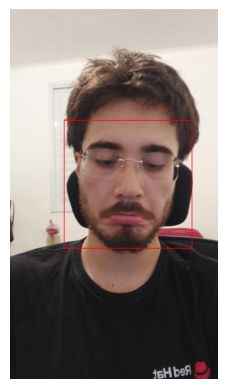

In [ ]:
####Teste com foto joão
new_image_path = "/content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/fotos-validacao/joao/joao-teste-tristeza.jpeg"

process_new_image(new_image_path, model_path)

Modelo carregado de: /content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/modelo_treinado.h5
**********************************************************

Rosto identificado: leandro
Emoção detectada (traduzida): medo 

TOPO:  116
DIREITA:  335
BAIXO:  206
ESQUERDA:  245
VETOR CARACTERISTICAS:  [-0.81000503  0.31589668 -0.14533283 -1.69445607 -1.36850232 -0.03723214
  0.37710448  1.13037865  0.31836195  1.11994777 -0.98323588 -0.27629824
 -0.62040277  0.97358966 -0.95767274 -1.53235327  0.36297527 -1.40755874
  2.66299848 -0.79595522  0.83196603  0.74351697 -1.35663289 -0.51611169
 -0.57884088  0.07274079  0.76156923  2.71224318 -1.28533253 -0.72285627
  1.31494486  2.73246281  0.53122585  0.48383367 -0.50995507  1.95820884
  0.51179281 -1.36499987 -0.52855632  0.38337623  1.4369944   0.44645705
  0.25281502  1.2775977  -1.29961059 -1.22321199  0.71935416  0.27464136
  0.50760502 -0.809708   -0.53275368  1.39589325  0.29281789 -2.84920217
  0.06672402  1.48546166 -0.39501167  0.88804372  0.1

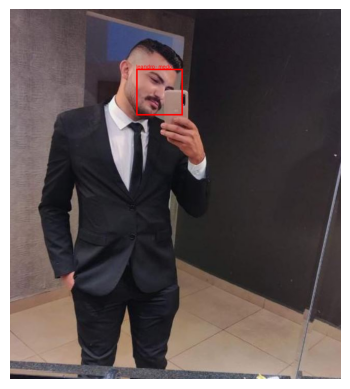

In [ ]:
####Teste com foto Leandro
new_image_path = "/content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/fotos-validacao/Leandro/leandro-teste.JPG"

process_new_image(new_image_path, model_path)

Modelo carregado de: /content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/modelo_treinado.h5
**********************************************************

Rosto identificado: fernanda
Emoção detectada (traduzida): feliz 

TOPO:  27
DIREITA:  562
BAIXO:  348
ESQUERDA:  241
VETOR CARACTERISTICAS:  [ 0.59294428  0.04540997 -2.11579213 -1.47733989 -1.21820139  1.14579026
 -1.59441746 -1.41639116  0.1885835   0.28901508 -1.30148153 -1.31074539
 -0.70825595  0.19800699 -1.91464876  1.18142122 -0.49643521 -1.71052092
  1.58378136  0.22071756  0.28184667 -1.48315155 -0.22433894  2.78216403
 -0.97647697 -0.11377297  1.23685662 -0.33783708 -1.33822776  0.33965906
 -0.91240876 -0.44143198 -3.93342855  1.996635    0.38689576  1.5649388
 -0.01591751 -1.79010555 -1.03077548 -0.0555586  -0.45176918  0.4996285
  1.35399669 -1.29570101  1.20138506 -0.17033154 -0.95268749 -0.65099291
  2.01807489 -1.10196485  1.46059744  3.77107522 -0.71030887  0.28521848
 -0.2894274  -0.73257331  0.06526674  0.54656907  0.33

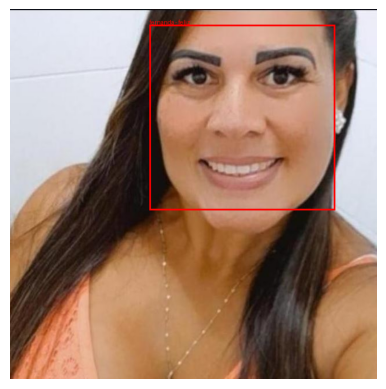

In [ ]:
####Teste com foto Fernanda
new_image_path = "/content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/fotos-validacao/fernanda-teste/fernanda-teste.JPG"

process_new_image(new_image_path, model_path)

Modelo carregado de: /content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/modelo_treinado.h5
**********************************************************

Rosto identificado: Pessoa Desconhecida
Emoção detectada (traduzida): feliz 

TOPO:  390
DIREITA:  513
BAIXO:  613
ESQUERDA:  291
VETOR CARACTERISTICAS:  [-0.46735685  0.85235683  0.19318619 -3.41966017 -0.79477558  1.47996469
  0.86093301 -0.7110491   0.8581963  -2.7993527  -0.6260896  -1.76755045
 -1.58372147  1.59091417 -1.08577637  2.63578763 -0.66171656 -2.63209094
 -0.3993556   1.642512   -0.52915827 -0.37754686  0.31340621  2.93587838
  0.94450196 -1.23587944 -0.44534057 -0.0198856  -2.10041161  0.75214641
  0.61744827  0.28469232 -2.28483444  2.17152084 -0.91564757  0.75927625
 -0.9637401  -1.0827285   1.3501693   1.12419545 -3.69900717  1.0978521
  0.66916398  0.094534    1.47891031 -1.24760842 -0.96782452 -0.50521043
  0.62917576 -2.69821792 -0.34470432  2.70048128  0.28603485 -0.09547047
  0.00722199  2.70581125  0.58298339 -0.5

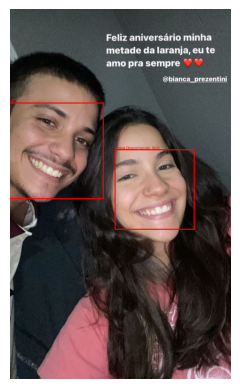

In [ ]:
####Teste com foto Caio
new_image_path = "/content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/fotos-validacao/Caio/irma-caio-teste2.jpeg"

process_new_image(new_image_path, model_path)

Modelo carregado de: /content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/modelo_treinado.h5
**********************************************************

Rosto identificado: buba
Emoção detectada (traduzida): feliz 

TOPO:  253
DIREITA:  494
BAIXO:  408
ESQUERDA:  339
VETOR CARACTERISTICAS:  [-1.00907806  0.12847511  2.03695201  0.29832328  1.12513518 -0.55788046
  0.91846113  0.20537949 -1.27446717  0.00945592  1.84690734 -0.76596414
  1.21470378 -1.70420222  1.54183605 -0.45196596 -1.10312145 -1.18174814
 -1.20806677 -2.10000463 -2.0165215   0.77538036 -1.74926093 -1.66620605
  2.15204891  1.31886106 -1.08774684 -0.6266526   2.58692707  0.545815
  0.8391911  -1.58378242 -1.0190263   0.60020498 -1.77505696 -2.02796674
  2.27600737 -0.0802154  -0.31748394  0.16601978  1.63625415  0.04110202
 -2.19758506 -0.0360094   0.35483068 -2.01523563 -1.33009556  1.31717781
 -1.59295757  0.85379583 -2.13633828 -0.51738855  0.89641541  0.02763649
 -2.19132224  0.10498713 -1.09691522 -1.94073599  0.47289

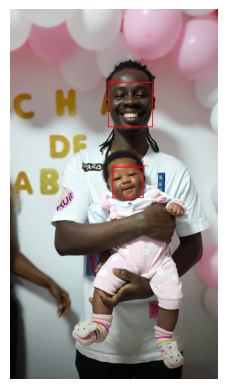

In [ ]:
####Teste com foto Buba
new_image_path = "/content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/fotos-validacao/Buba/buba-teste3.jpeg"

process_new_image(new_image_path, model_path)

Modelo carregado de: /content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/modelo_treinado.h5
**********************************************************

Rosto identificado: joao
Emoção detectada (traduzida): triste 

TOPO:  480
DIREITA:  788
BAIXO:  1035
ESQUERDA:  233
VETOR CARACTERISTICAS:  [-3.64706995e-02  2.92442645e-01  2.24325778e+00  8.58742995e-01
  1.20493969e+00  5.60234637e-01 -2.37008091e+00  1.55416525e+00
 -1.17465558e+00  6.03754582e-01  1.18134375e-01  2.09898851e-01
 -1.32953016e-03  1.24483363e-01  2.58537274e-01  7.87244880e-01
 -1.17111640e-01  1.36741034e+00  2.67255390e-01  5.49489133e-01
 -4.58304248e-01  1.88158168e+00 -1.18753973e-01 -1.92372988e+00
  4.32315177e-01 -1.69433248e+00  1.09084112e+00 -1.69404883e-01
 -8.41559998e-01 -2.02996272e-01 -1.15853560e+00 -1.01486072e+00
  1.74716447e+00 -6.83632669e-01  1.19722362e+00  7.00654451e-01
  2.46496476e-02  1.47617125e+00 -8.48336084e-01  7.58878211e-01
  2.94857442e-01  1.31951740e+00  5.66854024e-01 -2.69261860

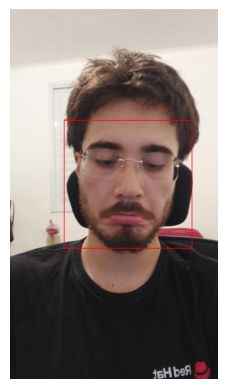

In [ ]:
####Teste com foto e sentimento - Tristeza
new_image_path = "/content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/fotos-validacao/joao/joao-teste-tristeza.jpeg"

process_new_image(new_image_path, model_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Modelo carregado de: /content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/modelo_treinado.h5
**********************************************************

Rosto identificado: Pessoa Desconhecida
Emoção detectada (traduzida): medo 

TOPO:  170
DIREITA:  562
BAIXO:  491
ESQUERDA:  241
VETOR CARACTERISTICAS:  [ 9.39635106e-02 -6.64733955e-01 -1.17136946e-01 -3.35538320e+00
 -2.88649620e+00  2.21598617e+00 -7.66457353e-01  5.47151467e-03
 -7.25389532e-01 -1.21227071e+00 -1.08870908e-01  3.50111861e-01
 -8.64188642e-01  2.74586002e-02  7.90738705e-01  7.85099749e-01
  1.34744507e+00 -2.04926165e+00 -2.63609631e+00  1.59092608e+00
 -1.61829495e+00  7.11506868e-01 -8.04703965e-01 -9.40471328e-01
 -1.32921736e-02  1.47016648e+00  1.31243202e+00  1.47033858e+00
  5.80746262e-02  2.65126638e-01 -6.47948115e-02  7.97592657e-01
 -1.68978922e-02  2.84105307e+00  2.01799905e-01  1.84689857e+00
 -3.20672744e+00 -3.14056609e+00  1.12941993e+00 -1.36899687e+00
 -6.38635234e-01 -5.75298623e-01 -7.16349551e-01

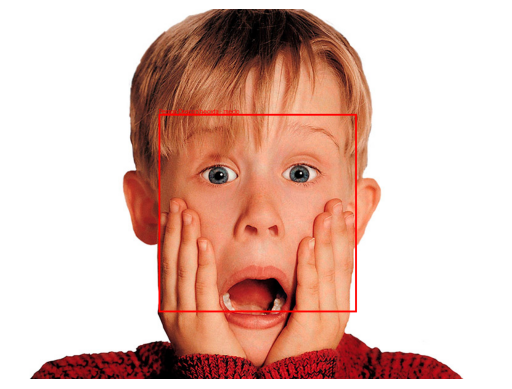

In [ ]:
####Teste com foto e sentimento - Medo (desconhecido)
new_image_path = "/content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/fotos-validacao/Medo_ap2_loiro.jpg"

process_new_image(new_image_path, model_path)

Modelo carregado de: /content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/modelo_treinado.h5
**********************************************************

Rosto identificado: Pessoa Desconhecida
Emoção detectada (traduzida): raiva 

TOPO:  337
DIREITA:  958
BAIXO:  1136
ESQUERDA:  159
VETOR CARACTERISTICAS:  [-1.00743073e+00  1.19186396e+00  1.71392286e-01  8.27561932e-01
 -5.67775606e-01  2.02736606e+00 -1.41562218e+00  1.44554147e+00
 -1.01450814e+00  3.06110916e-01 -4.25629690e-01  4.09121961e-01
  1.41679981e-01 -9.56433883e-02 -6.11246465e-01  2.04437280e+00
 -1.20143025e+00 -2.90369826e-01  1.52898488e+00  1.94918364e+00
  3.92020093e-01  2.01165787e+00 -1.25610890e+00 -1.51862593e+00
 -7.85266120e-01 -7.34975282e-01  2.63406338e-01  1.82760746e-01
 -1.50969604e+00  2.99225219e-01 -7.85965011e-01 -1.14329929e+00
  3.35804629e-01  7.34360862e-01 -3.72367202e-03 -1.28514541e+00
 -7.69477600e-01  9.77510111e-01 -1.90385626e+00  1.35220532e+00
 -8.21894614e-01  3.33854001e+00 -3.39473469e-

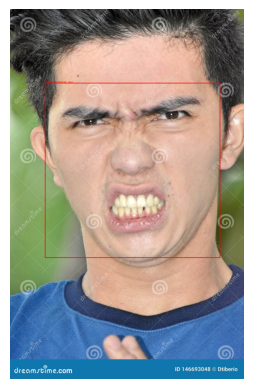

In [ ]:
####Teste com foto e sentimento - raiva (desconhecido)
new_image_path = "/content/drive/MyDrive/RECONHECIMENTO IMAGEM/ap2/fotos-validacao/pessoa raiva ap2.jpg"

process_new_image(new_image_path, model_path)